# Compute S

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.99:8787/status,
Dashboard: http://10.148.0.99:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.99:53616,Workers: 0
Dashboard: http://10.148.0.99:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
DL =100*1e3 #meters
DT = 3*3600 #seconds
id_aviso = 'aviso__0__adt__es_cstrio_z15__drifter_x'
id_co = 'co__0__adt_filtered__es_cstrio_z15__drifter_x'

# Count

In [5]:
ds = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}.zarr'))
print(f'all            {ds.nb_coloc.sum().values}')
gps = [l for l in labels if 'gps' in l]
print(f'all gps        {ds.sel(drifter_sat_year=gps).nb_coloc.sum().values}')
argos = [l for l in labels if 'argos' in l]
print(f'all argos      {ds.sel(drifter_sat_year=argos).nb_coloc.sum().values}')
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}_drogued.zarr')).persist()
print(f'drogued all    {dsd.nb_coloc.sum().values}')
gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
print(f'drogued gps    {dsd.sel(drifter_sat_year=gps).nb_coloc.sum().values}')
argos = [l for l in dsd.drifter_sat_year.values if 'argos' in l]
print(f'drogued argos  {dsd.sel(drifter_sat_year=argos).nb_coloc.sum().values}')
dsud = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}_undrogued.zarr')).persist()
print(f'undrogued all    {dsud.nb_coloc.sum().values}')
gps = [l for l in dsud.drifter_sat_year.values if 'gps' in l]
print(f'undrogued gps    {dsud.sel(drifter_sat_year=gps).nb_coloc.sum().values}')
argos = [l for l in dsud.drifter_sat_year.values if 'argos' in l]
print(f'undrogued argos  {dsud.sel(drifter_sat_year=argos).nb_coloc.sum().values}')

all            2222836
all gps        1210043
all argos      1012793
drogued all    946737
drogued gps    578931
drogued argos  367806
undrogued all    1276099
undrogued gps    631112
undrogued argos  644987


# Datasets 

In [6]:
def global_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

In [174]:
def plot_closure_bar(ds, id_, ax, title=1):
    """ Plot closure bars for a combination on the axis ax.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']

    # ACC X
    ax.bar(1.5, (np.sqrt(ds[acc]) + np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, (np.sqrt(ds[acc]) - np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, ds['exc_acc_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc], bottom = ds['exc_acc_' + id_],
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) + np.sqrt(ds[cor]))**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) - np.sqrt(ds[cor]))**2,
           color='w', width = 0.45, zorder=3, align = 'center', )
    ax.bar(2, ds['exc_coriolis_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor], bottom = ds['exc_coriolis_' + id_],
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) + np.sqrt(ds[ggrad]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) - np.sqrt(ds[ggrad]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, ds['exc_ggrad_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad], bottom = ds['exc_ggrad_' + id_],
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) + np.sqrt(ds[wd]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) - np.sqrt(ds[wd]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, ds['exc_wind_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd], bottom = ds['exc_wind_' + id_],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of ms^2
    ax.bar(1,ds[acc],
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor], bottom = ds[acc],
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad], bottom = ds[acc]+ds[cor],
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd], bottom = ds[acc]+ds[cor]+ds[ggrad],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]+ds[cor]+ds[ggrad]+ds[wd]
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['sum_'+id_]
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    ggrad_tick='$\n $+'.join(g)
    w = ds['es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace(']','').split(' from')
    wd_tick = '\n from'.join(w)
    ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values}, coriolis:{ds[cor].values}, ggrad:{ds[ggrad].values}, wind:{ds[wd].values}')

In [8]:
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100
def RSE_df(ds):
    RSE = []
    for id_ in ds.id_comb.values:
        RSE.append(RSE_id(ds, id_))
    return pd.DataFrame({'id_comb':ds.id_comb, 'RSE':RSE}).set_index('id_comb')

In [78]:
# ALL
ds['drifter_sat_year'] = labels
ds_ = global_ms_drifter_sat_year(ds).sel(id_comb=[id_aviso, id_co])
RSE = RSE_df(ds_)
gps = [l for l in labels if 'gps' in l]
ds_gps = global_ms_drifter_sat_year(ds.sel(drifter_sat_year=gps)).sel(id_comb=[id_aviso, id_co])
RSE_gps = RSE_df(ds_gps)
argos = [l for l in labels if 'argos' in l]
ds_argos = global_ms_drifter_sat_year(ds.sel(drifter_sat_year=argos)).sel(id_comb=[id_aviso, id_co])
RSE_argos = RSE_df(ds_argos)

# Drogue
dsd_ = global_ms_drifter_sat_year(dsd).sel(id_comb=[id_aviso, id_co])
RSEd = RSE_df(dsd_)
gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
dsd_gps = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=gps)).sel(id_comb=[id_aviso, id_co])
RSEd_gps = RSE_df(dsd_gps)
argos = [l for l in dsd.drifter_sat_year.values if 'argos' in l]
dsd_argos = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=argos)).sel(id_comb=[id_aviso, id_co])
RSEd_argos = RSE_df(dsd_argos)


# Undrogue
dsud_ = global_ms_drifter_sat_year(dsud).sel(id_comb=[id_aviso, id_co])
RSEud = RSE_df(dsud_)
gps = [l for l in dsud.drifter_sat_year.values if 'gps' in l]
dsud_gps = global_ms_drifter_sat_year(dsud.sel(drifter_sat_year=gps)).sel(id_comb=[id_aviso, id_co])
RSEud_gps = RSE_df(dsud_gps)
argos = [l for l in dsud.drifter_sat_year.values if 'argos' in l]
dsud_argos = global_ms_drifter_sat_year(dsud.sel(drifter_sat_year=argos)).sel(id_comb=[id_aviso, id_co])
RSEud_argos = RSE_df(dsud_argos)

In [79]:
RSE['GPS']=RSE_gps
RSE['Argos']=RSE_argos
RSE['Drogued Argos']=RSEd_argos
RSE['Drogued GPS']=RSEd_gps
RSE['Undrogued Argos']=RSEud_argos
RSE['Undrogued GPS']=RSEud_gps

In [80]:
RSE

,RSE,GPS,Argos,Drogued Argos,Drogued GPS,Undrogued Argos,Undrogued GPS
id_comb,,,,,,,
aviso__0__adt__es_cstrio_z15__drifter_x,44.175766,38.309478,50.109561,41.182238,30.488973,54.702221,44.241416
co__0__adt_filtered__es_cstrio_z15__drifter_x,55.267480,51.538697,59.095925,53.874539,46.781849,61.849950,55.254806


_____
# GPS VS ARGOS

Text(0, 0.5, 'RSE [%]')

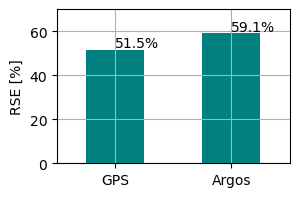

In [161]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
RSE_ = RSE.reset_index().rename(columns={'id_comb':'Combinations type'}).set_index('Combinations type').transpose().rename(index={'id_comb':'Combinations type'})
RSE_[id_co].loc[['GPS', 'Argos']].plot.bar(ax=ax, rot=0,color='teal')
ai=-0.25
for a in ['GPS', 'Argos']: 
    #ax.annotate(f'{round(RSE_[id_aviso].loc[a], 1)}%', (ai, RSE_[id_aviso].loc[a]+1))
    ax.annotate(f'{round(RSE_[id_co].loc[a], 1)}%', (ai + 0.25, RSE_[id_co].loc[a]+1))
    ai+=1
ax.grid()
ax.set_ylim(0,70)
ax.set_ylabel('RSE [%]')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3))
#fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# Drogues VS ARGOS

Text(0, 0.5, 'RSE [%]')

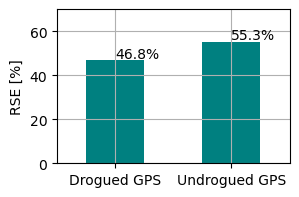

In [166]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
RSE_ = RSE.reset_index().rename(columns={'id_comb':'Combinations type'}).set_index('Combinations type').transpose().rename(index={'id_comb':'Combinations type'})
RSE_[id_co].loc[['Drogued GPS', 'Undrogued GPS']].plot.bar(ax=ax, rot=0,color='teal')
ai=-0.25
for a in ['Drogued GPS', 'Undrogued GPS']: 
    #ax.annotate(f'{round(RSE_[id_aviso].loc[a], 1)}%', (ai, RSE_[id_aviso].loc[a]+1))
    ax.annotate(f'{round(RSE_[id_co].loc[a], 1)}%', (ai + 0.25, RSE_[id_co].loc[a]+1))
    ai+=1
ax.grid()
ax.set_ylim(0,70)
ax.set_ylabel('RSE [%]')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3))
#fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

Text(0, 0.5, 'RSE [%]')

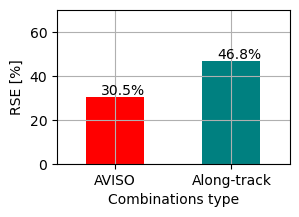

In [168]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
RSE_ = RSE.reset_index().rename(columns={'id_comb':'Combinations type'}).set_index('Combinations type').transpose().rename(index={'id_comb':'Combinations type'})
RSE_.rename(columns={id_aviso:'AVISO', id_co:'Along-track', }).loc['Drogued GPS'].plot.bar(ax=ax, color=['red', 'teal'], rot=0,)
ai=-0.125
for a in ['Drogued GPS']: 
    ax.annotate(f'{round(RSE_[id_aviso].loc[a], 1)}%', (-0.125, RSE_[id_aviso].loc[a]+1))
    ax.annotate(f'{round(RSE_[id_co].loc[a], 1)}%', (1-0.125, RSE_[id_co].loc[a]+1))
ax.grid()
ax.set_ylim(0,70)
ax.set_ylabel('RSE [%]')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3))
#fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# S bars

acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:1.8011328969622654e-10, wind:1.8053452017610314e-11
acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:2.7947198645710157e-10, wind:1.8053452017610314e-11


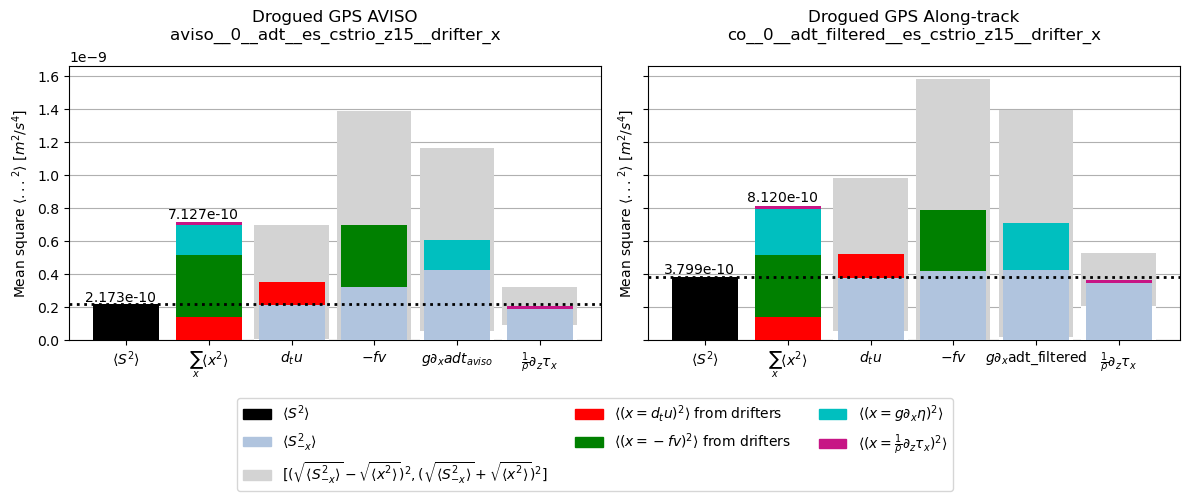

In [176]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(12,5))
plot_closure_bar(dsd_gps, id_aviso,axs[0], title = 'Drogued GPS AVISO')
plot_closure_bar(dsd_gps, id_co ,axs[1], title = 'Drogued GPS Along-track')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [177]:
cluster.close()